In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


# Introduction
The Sloan Digital Sky Survey (SDSS) is an imaging and redshift survey. The survey recorded the redshift and spectral information of galaxies, stars, and quasars for over 20 yeears. Given that different sorts of objects have different spectral properties and tend to be found in different redshift ranges, it is reasonable to assume that a classification model can be trained to determine whether an object is a galaxy, quasar, or star from its spectral and positional information. In this notebook, a model is trained to accomplish such a task.

# Loading Data

In [36]:
df = pd.read_csv('Skyserver_SQL6_30_2022 3_34_55 PM.csv', header=1)
print('Dataframe shape: ', df.shape)
df.head()

Dataframe shape:  (500000, 18)


,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1237680311226400971,352.476340,32.083681,19.22127,18.89125,18.77551,18.64375,18.57708,8111,301,4,37,8743832275874240512,QSO,1.653339,7766,58395,340
1,1237680311227187450,354.438295,32.195653,19.26509,18.22012,17.82656,17.64138,17.58769,8111,301,4,49,8737113155032078336,STAR,-0.000424,7760,58080,472
2,1237657401336660259,119.622158,30.650825,19.20690,17.57562,16.51169,16.00991,15.63780,2777,301,3,78,1194649389579134976,GALAXY,0.157430,1061,52641,253
3,1237657401334890829,116.645997,27.560866,18.95453,17.31941,16.45584,16.06454,15.73799,2777,301,3,51,1192374499635390464,GALAXY,0.081241,1059,52618,169
4,1237657401344983213,137.187349,43.596885,19.19234,17.65800,16.77064,16.33491,16.03147,2777,301,3,205,935790811474323456,GALAXY,0.176956,831,52294,611


In [37]:
df.dtypes

objid          int64
ra           float64
dec          float64
u            float64
g            float64
r            float64
i            float64
z            float64
run            int64
rerun          int64
camcol         int64
field          int64
specobjid     uint64
class         object
redshift     float64
plate          int64
mjd            int64
fiberid        int64
dtype: object

# Data Cleaning
Data Cleaning here should begin with a discussion of the features. Full details for each features can be found on the SDSS glossary [here](https://www.sdss.org/dr17/help/glossary/), with the exception of the color filters, a discussion of which is linked in the relevant part below. The features can be classified as follows.

Features that identify objects:
* specobjid for identifying optical spectroscoptic objects.
* objid for identifying objects in SDSS' Catalog Archive Server image galary.

Object position/velocity:
* ra is right ascension (a spherical coordinate analogous to longitude)
* dec is declination (a spherical coordinate analogous to latitude)
* redshift: a unitless measure quantifying how fast an object is receding from the telescope. Can approximate distance if v << c. Notably, this measures how much the wavelength of light is stretched with respect to when the light is emitted, mainly due to the expansion of space.
Where the assumption that redshift approximates distance holds, these three features comprise a spherical coordinate system, where redshift is radial distance, declination is the polar angle and right ascension is the azimuthal angle.

[Color filters](https://www.sdss.org/instruments/camera/), the center wavelength of each is given below. Each filter allows a range of wavelengths, thus they are described with a [range of colors](https://www.physics.unlv.edu/~jeffery/astro/photometry/photometry_sdss.html). Each measurement in each feature is a magnitude, a unitless measuree of brightness. Collectively, these features give information about an object's color.
* u: near ultraviolet, 355.1 nm
* g: violet/blue/green, 468.6 nm
* r: yellow/orange/red, 616.6 nm
* i: red/near infrared, 7480 nm
* z: near infrared, 8932

Telescope/imaging Properties:
* Run: A run is a subdivision of a great circle from pole to pole, it being impossible to observe such a great circle in a single pass.
* Rerun: Reprocessing of a run.
* Camcol: the camera consists of six columns of five imaging devices. The camcol feature identifies the output of a single column of imaging devices.
* Field: The portion of a camcol that is processed at a time.
* plate: spectroscopic observations are obtained using plates in which holes are drilled and optical fibers subsequently passed through the hole, each fiber corresponding to an object. This feature gives the serial number of the plate used to make an observation.
* mjd: modified Julian date, the number of days since midnight November 17, 1858, a date chosen for irrelevant historical reasons.
* fiberid: the id of the fiber at which light from an object is directed.

Target feature:
* class: identifies an object as a quasar (QSO), galaxy or star.


This is a lot of features, but the **bottom line** is quite simple: the goal is to classify objects given information about the object, not information about an observation. **Thus an object's position, velocity, and color are important and retained.** Information about the row of imaging devices used, the plate used, the IDs assigned in the SDSS system are unimportant and dropped.

## Dropping Irrelevant Features
Only features containing positional information, spectral information and objects' classes are retained. The rest are dropped.

In [38]:
# Select features not identifying objects
data_cols = ['ra', 'dec', 'redshift', 'u', 'g', 'r', 'i', 'z', 'class']
df = df[data_cols]

## Checking for NaNs

In [39]:
# Prints out columns with NaN values
for col in df.columns:
    if df[df[col].isna()].shape[0] > 0:
        print(col)

# Exploratory Data Analysis

In [40]:
df.describe()

,ra,dec,redshift,u,g,r,i,z
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,179.657955,24.217654,0.174435,18.633463,17.410594,16.889028,16.556761,16.400485
std,77.444418,19.780303,0.440868,0.830478,0.985411,1.131594,28.354236,28.357057
min,0.001914,-19.669456,-0.010111,10.170250,9.300097,8.814259,-9999.000000,-9999.000000
25%,140.272011,7.284476,0.000004,18.206380,16.850770,16.199777,15.869240,15.625187
50%,181.827436,22.674078,0.045212,18.867425,17.517245,16.900995,16.613735,16.444330
75%,224.340307,39.077357,0.096040,19.267780,18.060050,17.592680,17.354930,17.248485
max,359.999615,84.852149,7.011245,19.600000,19.996050,33.209920,32.349170,30.017040


Without applying any sort of methodology like the IQR * 1.5 rule, there are clearly outliers in the i and z color filter features. SDSS uses asinh magnitudes, so negative magnitudes are possible, but values of -9999 are almost certainly erroneous.

In [41]:
X = df[['ra', 'dec', 'redshift', 'u', 'g', 'r', 'i', 'z']]
y = df['class']

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=1234)

In [42]:
# Create dataframe with just train data
df = pd.DataFrame(x_train, columns=['ra', 'dec', 'redshift', 'u', 'g', 'r', 'i', 'z']).join(df['class'], how='inner')
df.head()

,ra,dec,redshift,u,g,r,i,z,class
227888,201.230296,26.783401,0.073707,18.90914,17.12531,16.18277,15.69390,15.35579,GALAXY
186481,174.350982,31.729207,0.105487,18.92881,17.75816,17.20813,16.85093,16.66774,GALAXY
251310,194.667877,28.768618,-0.000329,19.30326,18.44737,18.20738,18.14739,18.12411,STAR
66923,31.168616,-6.735151,1.672967,19.47543,19.21040,19.16753,18.99148,19.08296,QSO
432023,232.478624,49.711671,-0.000729,19.25548,18.88137,19.25228,19.57324,20.00162,STAR


## Outlier Removal
Before applying a heuristic to remove outliers, which may be overly conservative and remove real observations with little benefit to performance, 

In [43]:
negative_z_band = df[(df['z'] < 0)]
negative_i_band = df[(df['i'] < 0)]
print(f'The z feature contains {negative_z_band.shape[0]} outliers.')
print(f'The i feature contains {negative_i_band.shape[0]} outliers.')

The z feature contains 3 outliers.
The i feature contains 4 outliers.


Above, it is clear that rather than a variety of objects that are simply dim within a couple of color bands, there are a few objects - only stars and galaxies - that are assigned -9999 in the i and z bands. I am unable to find any reasoning for this in the SDSS documentation. As such, I drop the observations in the table above, taking into account that there are only 8 observations.

In [45]:
# Removes objects with i or z band magnitudes below zero.
df = df[(df['i'] >= 0) & (df['z'] >= 0)]

## Univariate Plotts

C:\Users\Patrick\AppData\Local\Temp/ipykernel_81200/507594464.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df.hist(ax = ax, bins=100)


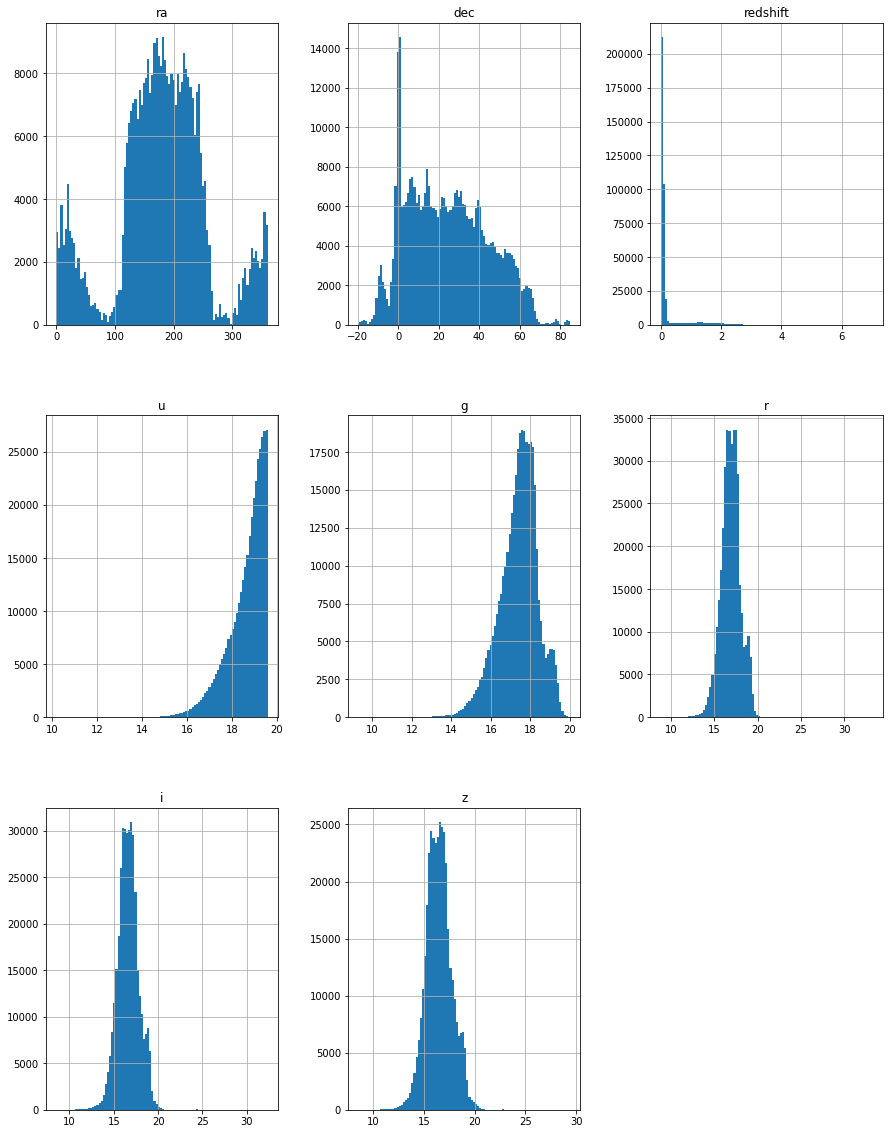

In [47]:
   fig = plt.figure(figsize = (15,20))
   ax = fig.gca()
   df.hist(ax = ax, bins=100)
   plt.show()

Unlike the in the i and z band, I would prefer not to eliminate high redshift objects. Some quasars are high redshift, and SDSS has actually made a point of [attempting to identify high-redshift quasars](https://www.sdss.org/dr12/algorithms/ancillary/boss/highz/).

<AxesSubplot:>

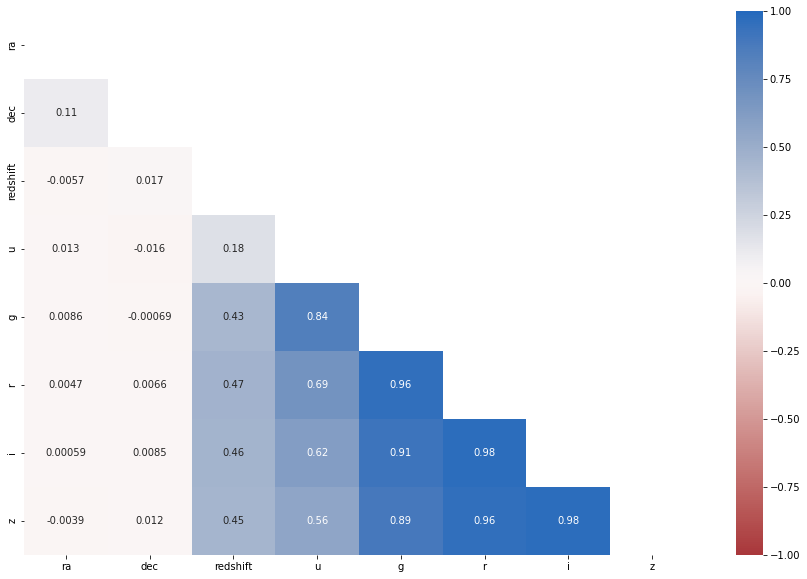

In [48]:
corr = df.corr()
mask = np.triu(corr)
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, cmap='vlag_r', mask=mask, ax=ax)

There are a few notable correlations. First, the correlation between redshift and color increases as the wavelength of light at the center of the band increases (with u having the shortest wavength at the center and z the longest). This makes sense. The higher an object's redshift, the more light from that object has stretched at by the point the light is observed. Second, there are some correlations between color bands. This is also unsurprising, particularly because these correlations are highest between adjacent color bands.

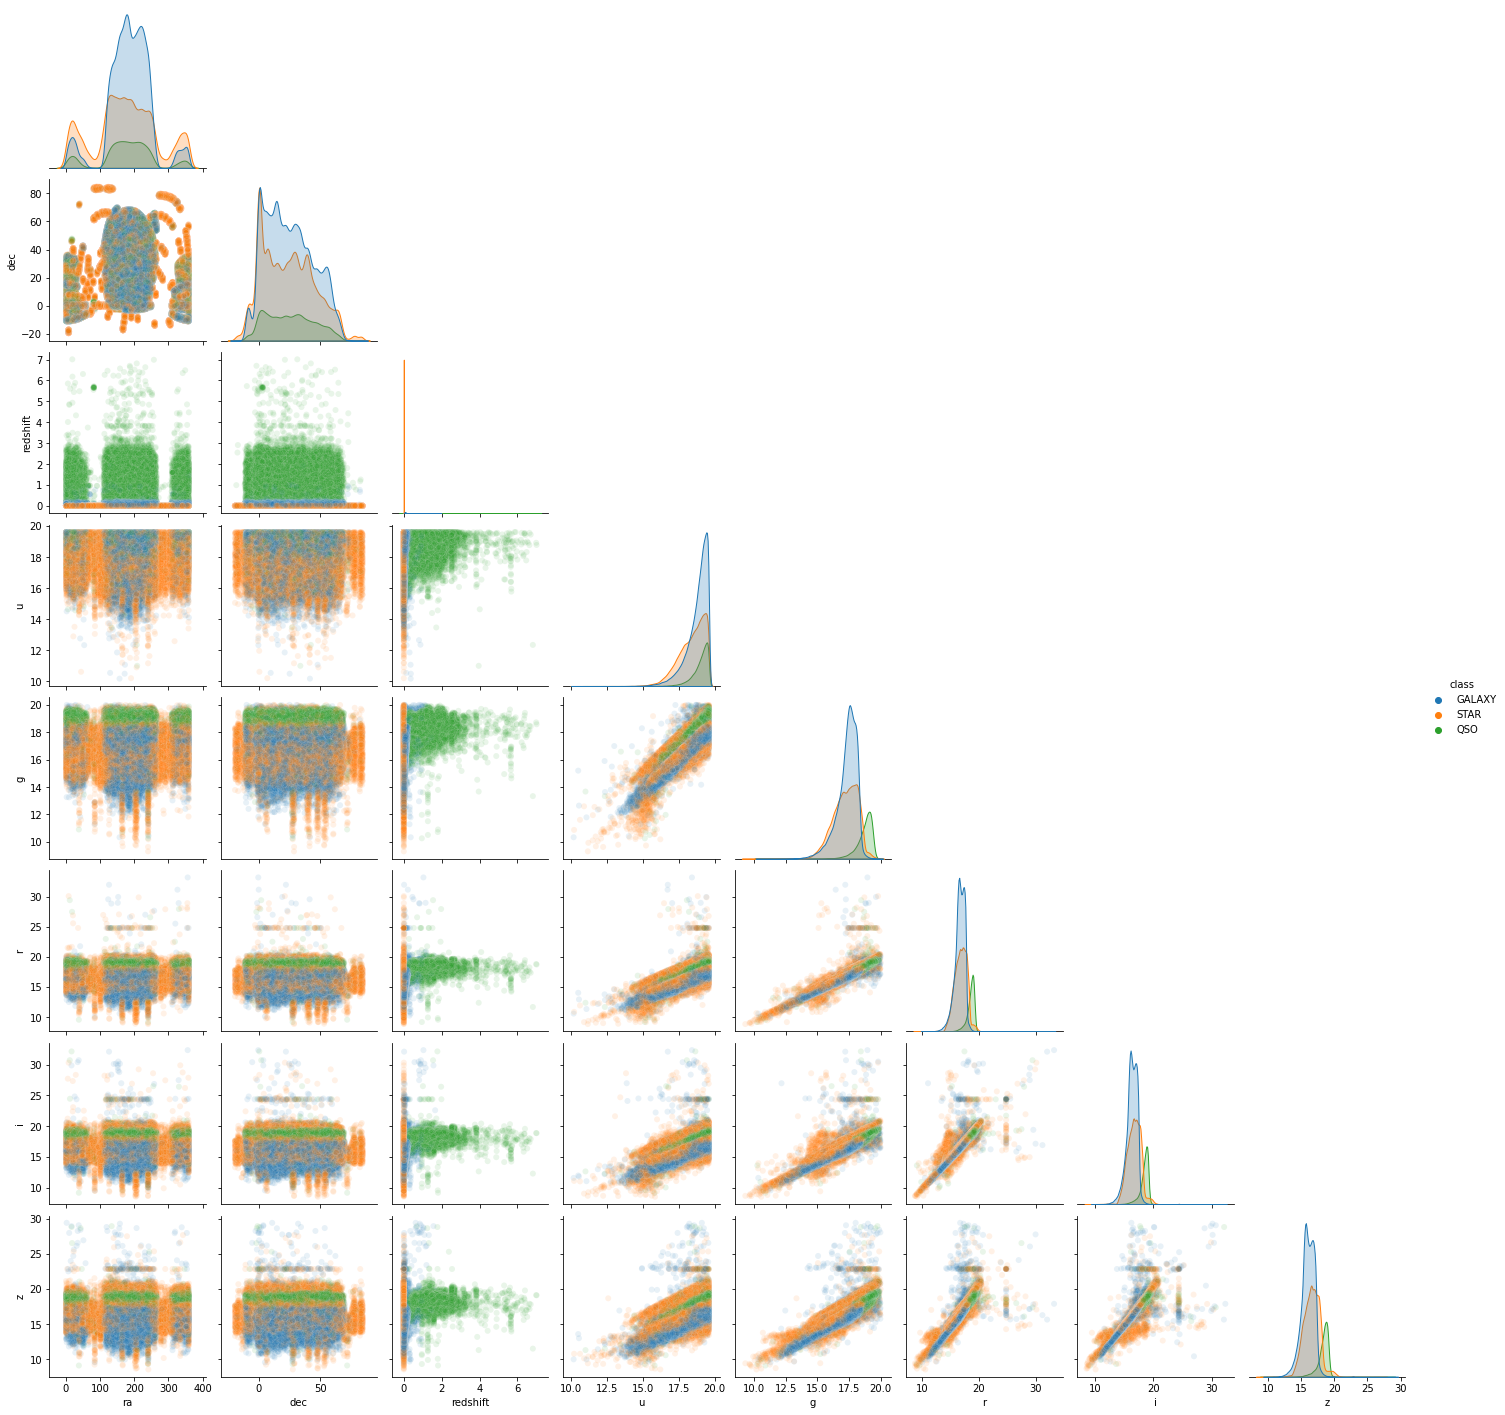

In [49]:
sns.pairplot(data=df, hue='class', corner=True,  plot_kws=dict(alpha=0.1))

Unsurprisingly, most of the higher redshift objects appear to be quasars. From this, it is equally unsurprising that (without testing for significance), that quasars tend to be brighter in the various color bands. The correlations between colors are also visible on the bivariate plots.

About 50.42% of the objects are given the GALAXY label.
About 38.69% of the objects are given the STAR label.
About 10.89% of the objects are given the QSO label.


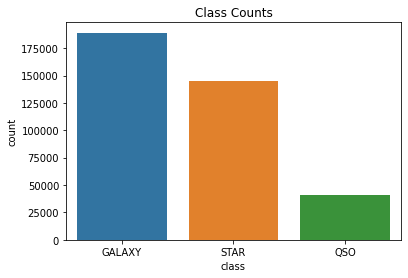

In [50]:
num_obj = df.shape[0]
for obj_class in df['class'].unique():
    num_class = df[df['class'] == obj_class].shape[0]
    perc_class = np.round(100*num_class/num_obj, decimals=2)
    print(f'About {perc_class}% of the objects are given the {obj_class} label.')

sns.countplot(data=df, x='class')
plt.title('Class Counts')
plt.show()

The dataset is substantially unbalanced. Galaxies make up half of the observed objects, and quasars make up less than half of the objects excluding galaxies. As such, a model may learn improperly if the imbalance is not corrected. Consider the edge case in which the model is excellent at detecting stars and galaxies but never identifies quasars correctly. This model would still receive an accuracy of 89%. As such, it is necessary to fix the data imbalance.

In [51]:
x_train = df[['ra', 'dec', 'redshift', 'u', 'g', 'r', 'i', 'z']]
y_train = df['class']

# Model Training
An ensemble classifier is trained on the training data. Specifically the ensemble is a bagging classifier consisting of 100 decision trees. The bagging classifier fits each tree on a subset of the data, the averages the predictions for each object. This helps prevent overfitting relatiive to using a single decision tree.

In [52]:
rf = BaggingClassifier(n_estimators=100, random_state=123)
rf.fit(x_train, y_train)

BaggingClassifier(n_estimators=100, random_state=123)

# Evaluation

In [53]:
test_acc = rf.score(x_test, y_test)
train_acc = rf.score(x_train, y_train)
print(f'Accuracy on the training set: {train_acc}')
print(f'Accuracy on the test set: {test_acc}')

Accuracy on the training set: 0.9999893331626639
Accuracy on the test set: 0.993096


The accuracy on both the trainiing and test seet are quite comparable, less than 1% apart. So the model is not overfit. Further, the accuracy is quite high on the test set at 99.3%, even without hyperparameter selection using cross validation. But given the uneven distribution of classes, it is essential to look at performance on each class.

In [54]:
y_hat = rf.predict(x_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

      GALAXY       0.99      1.00      0.99     63218
         QSO       0.98      0.96      0.97     13686
        STAR       1.00      1.00      1.00     48096

    accuracy                           0.99    125000
   macro avg       0.99      0.99      0.99    125000
weighted avg       0.99      0.99      0.99    125000



Above, the precision, recall ands f1 score are presented for each class. For a given class, the precision measures the portion of positive identifications that were true positives, and recall measures the portion of the instances of the class that were identified. The f1 score is a mean of both.

Performance is quite good on all three classes. Performance is lowest on the smallest minority class, quasars (QSO), but it is not substantially lower than on the other classes. When the model identifies an object as a quasar, it is right 98% of the time, and it properly identifies 96% of the quasars.

# Conclusion
A bagging classifier is able to classify models with a high degree of accuracy and high f1 scores for each class.